# EDA of Spaceship Titanic

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler, OneHotEncoder

In [2]:
df = pd.read_csv('../input/train.csv')
df.shape

(8693, 14)

In [3]:
pd.set_option('display.max_columns', None)
df.head()

,PassengerId,HomePlanet,CryoSleep,Cabin,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Name,Transported
0,0001_01,Europa,False,B/0/P,TRAPPIST-1e,39.0,False,0.0,0.0,0.0,0.0,0.0,Maham Ofracculy,False
1,0002_01,Earth,False,F/0/S,TRAPPIST-1e,24.0,False,109.0,9.0,25.0,549.0,44.0,Juanna Vines,True
2,0003_01,Europa,False,A/0/S,TRAPPIST-1e,58.0,True,43.0,3576.0,0.0,6715.0,49.0,Altark Susent,False
3,0003_02,Europa,False,A/0/S,TRAPPIST-1e,33.0,False,0.0,1283.0,371.0,3329.0,193.0,Solam Susent,False
4,0004_01,Earth,False,F/1/S,TRAPPIST-1e,16.0,False,303.0,70.0,151.0,565.0,2.0,Willy Santantines,True


## Let's understand the data

The dataset contains 14 columns and 8693 rows. It means on the day of *Spaceship Titanic's collision* with the spacetime anomaly total **8693 passengers** were travelling. The have been given a set of personal records, recovered from the ship's damaged computer system. The description of the features are as follows:

- **PassengerId**: A unique identifier for the passenger. Each Id takes the form gggg_pp where gggg indicates a group the passenger is travelling with and pp is the passenger's number within that group. People in a group are often family numbers, but not always.
- **HomePlanet**: The planet the passenger departed from, typically their planet of permanent resisdence.
- **CryoSleep**: Indicated whether the passenger elected to be put into suspended animation for the duration of the voyage. Passengers in cryosleep are confined to their cabins.
- **Cabin**: The cabin number where the passenger is staying. Takes the form **deck/num/side**, where **side** can be either **P** (port) or **S** (starboard).
- **Destination**: The planet the passenger will be debarking to.
- **Age**: The age of the passenger.
- **VIP**: Whether the passenger has paid for special VIP service during the voyage.
- **RoomService**, **FoodCourt**, **ShoppingMall**, **Spa**, **VRDeck**: Amount the passenger has billed at each of the Spaceship Titanic's many luxury amenities.
- **Name**: The first and last names of the passenger.
- **Transported**: Whether the passenger was transported to another dimension. This is the target, the column we have to predict.

In [4]:
# Drop the PassengerId as it is not useful
df.drop('PassengerId', axis=1, inplace=True)

## Data Cleaning

In [5]:
# Check for missing values
# df.isna().sum()

missing_values = pd.DataFrame({
    'Missing Values': df.isna().sum(),
    'Percentage': df.isna().sum() / df.shape[0] * 100
})
missing_values

,Missing Values,Percentage
HomePlanet,201,2.312205
CryoSleep,217,2.496261
Cabin,199,2.289198
Destination,182,2.093639
Age,179,2.059128
VIP,203,2.335212
RoomService,181,2.082135
FoodCourt,183,2.105142
ShoppingMall,208,2.392730
Spa,183,2.105142


Let's check what would be the shape of dataframes if we drop all the rows with missing values.

In [6]:
# Drop all rows with missing values
df_del_missing = df.dropna()
print(f'Shape of dataframe if we delete all rows with missing values: {df_del_missing.shape}')

change_in_shape = df.shape[0] - df_del_missing.shape[0]
print(f'Rows are reduced by {change_in_shape/df.shape[0] * 100:.2f}%')

Shape of dataframe if we delete all rows with missing values: (6606, 13)
Rows are reduced by 24.01%


So even though missing percentage are around 2% for most of the columns, we will lose 10% of the data if we drop all the rows with missing values. So we will have to impute the missing values with some strategy.

**Strategy for imputing missing values:**

For our first model we will just impute the missing numerical values with the mean of the column and missing categorical values with the mode of the column.
After our initial model we can try to impute the missing values with some other strategy and see if it improves the model.

In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8693 entries, 0 to 8692
Data columns (total 13 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   HomePlanet    8492 non-null   object 
 1   CryoSleep     8476 non-null   object 
 2   Cabin         8494 non-null   object 
 3   Destination   8511 non-null   object 
 4   Age           8514 non-null   float64
 5   VIP           8490 non-null   object 
 6   RoomService   8512 non-null   float64
 7   FoodCourt     8510 non-null   float64
 8   ShoppingMall  8485 non-null   float64
 9   Spa           8510 non-null   float64
 10  VRDeck        8505 non-null   float64
 11  Name          8493 non-null   object 
 12  Transported   8693 non-null   bool   
dtypes: bool(1), float64(6), object(6)
memory usage: 823.6+ KB


In [8]:
# Numerical and Categorical features

num_cols = df.select_dtypes(include=np.number).columns
cat_cols = df.select_dtypes(include='object').columns

## Exploratory Data Analysis

In [9]:
def analyze_categorical_feature(df, feature, target="Transported"):
    """
    Analyze a categorical feature in the context of the target variable.

    Parameters:
    df (pd.DataFrame): The dataframe containing the data.
    feature (str): The name of the categorical feature to analyze.
    target (str): The target variable for analysis. Default is "Transported".

    Returns:
    pd.DataFrame: A dataframe summarizing the count and percentage distribution 
                  of the feature, along with the transport status percentages.
    """
    # Calculate the distribution and transport percentages
    summary_df = pd.DataFrame({
        "Count": df[feature].value_counts(),
        "Percentage": df[feature].value_counts(normalize=True) * 100,
        "Transported": df.groupby(feature)[target].value_counts(normalize=True).unstack()[True] * 100,
        "Not Transported": df.groupby(feature)[target].value_counts(normalize=True).unstack()[False] * 100
    })

    # Plot the feature distribution with respect to the target
    sns.countplot(df, x=feature, hue=target)
    plt.title(f'Distribution of {feature} with respect to {target}')
    plt.show()

    # Return the summary dataframe
    return summary_df

### Transported

First we will check how many passengers were transported to an alternate dimension during the *Spaceship Titanic's collision* with the spacetime anomaly.

             Count  Percentage
Transported                   
True          4378   50.362361
False         4315   49.637639


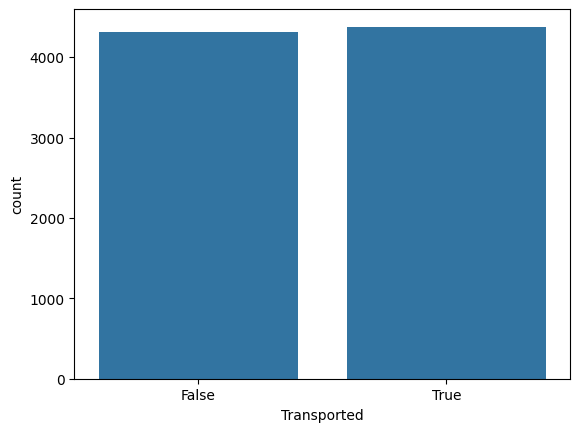

In [10]:
transported = pd.DataFrame({
    "Count":df.Transported.value_counts(),
    "Percentage":df.Transported.value_counts(normalize=True)*100
})
print(transported)

sns.countplot(df, x="Transported")
plt.show()

The total number of passengers transported and not transported are 4347 and 4346 respectively. It means the dataset is balanced.

### Catagorical Features

We will analyze the catagorical features in the dataset.

#### HomePlanet

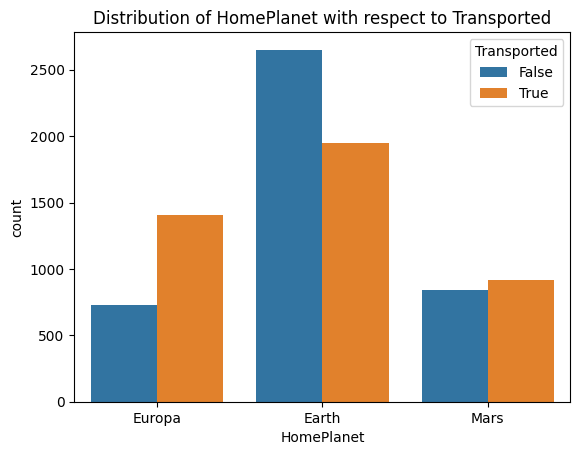

            Count  Percentage  Transported  Not Transported
HomePlanet                                                 
Earth        4602   54.192181    42.394611        57.605389
Europa       2131   25.094206    65.884561        34.115439
Mars         1759   20.713613    52.302445        47.697555


In [11]:
homeplanet_summary = analyze_categorical_feature(df, "HomePlanet")
print(homeplanet_summary)

- About half of the passengers are from Earth. 
- Chance of being not transported is highest for passengers from Earth. While passengers from Europa have the highest chance of being transported.

#### CryoSleep

Indicated whether the passenger elected to be put into suspended animation for the duration of the voyage. Passengers in cryosleep are confined to their cabins.

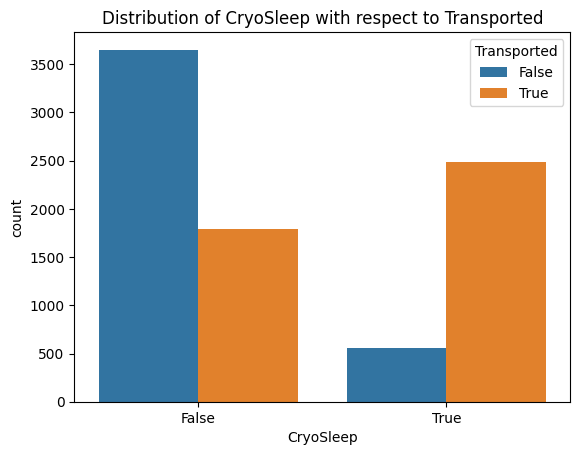

           Count  Percentage  Transported  Not Transported
CryoSleep                                                 
False       5439    64.16942    32.892076        67.107924
True        3037    35.83058    81.758314        18.241686


In [12]:
cryosleep_summary = analyze_categorical_feature(df, "CryoSleep")
print(cryosleep_summary)

About two-third of the passengers were not in cryosleep. The chance of being transported is higher for passengers in cryosleep. So in future if you don't want to be transported to another dimension incase of a spacetime anomaly, you better not be in cryosleep.

#### VIP

Whether the passenger has paid for special VIP service during the voyage.

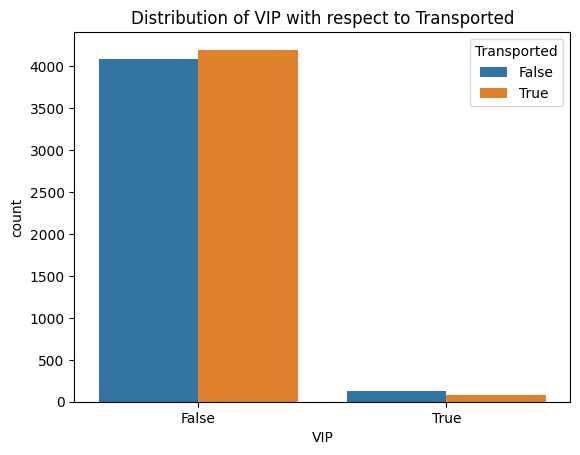

       Count  Percentage  Transported  Not Transported
VIP                                                   
False   8291   97.656066    50.633217        49.366783
True     199    2.343934    38.190955        61.809045


In [13]:
vip_summary = analyze_categorical_feature(df, "VIP")
print(vip_summary)

Majority of the passengers have not paid for VIP service. Although the change of being transported are bit lower for passengers who have paid for VIP service. 

#### Name

In [14]:
print(f"Total number of rows: {df.Name.shape[0]}")
unique_names = pd.DataFrame({
    "Count": [df.Name.value_counts().sum().item()],
    "Percentage": [df.Name.value_counts().sum().item()/df.shape[0]*100]
}, index=["Unique Names"])

unique_names

Total number of rows: 8693


,Count,Percentage
Unique Names,8493,97.699298


Almost all the names are unique. So we can't use this feature directly in our model. But when building second model we can try to extract some information from the names.

In [15]:
df_name = df.Name.str.split(expand=True)
df_name.columns = ["First_Name", "Last_Name"]
df_name.head()

,First_Name,Last_Name
0,Maham,Ofracculy
1,Juanna,Vines
2,Altark,Susent
3,Solam,Susent
4,Willy,Santantines


In [16]:
df_name.First_Name.value_counts()

First_Name
Idace      13
Loree      12
Dandra     11
Kaye       11
Gwendy     11
           ..
Algiedi     1
Pok         1
Alraid      1
Macon       1
Sergie      1
Name: count, Length: 2706, dtype: int64

In [17]:
df_name.Last_Name.value_counts()

Last_Name
Casonston     18
Oneiles       16
Domington     15
Litthews      15
Fulloydez     14
              ..
Maglible       1
Valing         1
Curry          1
Halexandez     1
Goods          1
Name: count, Length: 2217, dtype: int64

Casonston and Oneiles are the most common last names. We will have to check if they all belong to the same group or not. Also we can check the vip status of these passengers and money spent on different amenities by these passengers.

In [18]:
last_name_count = df_name.Last_Name.value_counts()
print(f"Number of unique last names: {last_name_count.shape[0]}")

# Number of passengers with the same last name
last_name_count.value_counts()

Number of unique last names: 2217


count
2     400
3     388
1     382
4     320
5     256
6     173
7     119
8      68
9      35
10     30
11     25
12      7
13      6
14      4
15      2
18      1
16      1
Name: count, dtype: int64

#### Destination

The planet the passenger will be debarking to.

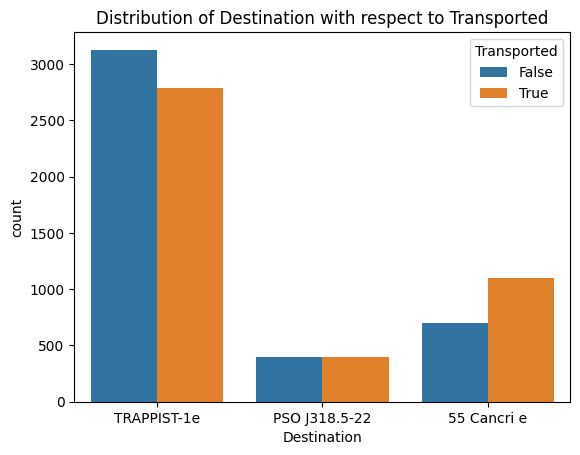

               Count  Percentage  Transported  Not Transported
Destination                                                   
55 Cancri e     1800   21.149101    61.000000        39.000000
PSO J318.5-22    796    9.352603    50.376884        49.623116
TRAPPIST-1e     5915   69.498296    47.117498        52.882502


In [19]:
destination_summary = analyze_categorical_feature(df, "Destination")
print(destination_summary)

#### Cabin

The cabin number where the passenger is staying. Takes the form deck/num/side, where side can be either P (port) or S (starboard).

Considering this feature contain information of deck, number and side of the cabin, we will extract these information in separate columns.

In [20]:
df.Cabin.value_counts().sum()

np.int64(8494)

In [21]:
df.Cabin.isna().sum()

np.int64(199)

In [22]:
df.Cabin[:5]

0    B/0/P
1    F/0/S
2    A/0/S
3    A/0/S
4    F/1/S
Name: Cabin, dtype: object

In [23]:
df.Cabin.str.split("/")

0          [B, 0, P]
1          [F, 0, S]
2          [A, 0, S]
3          [A, 0, S]
4          [F, 1, S]
            ...     
8688      [A, 98, P]
8689    [G, 1499, S]
8690    [G, 1500, S]
8691     [E, 608, S]
8692     [E, 608, S]
Name: Cabin, Length: 8693, dtype: object

Cabin number is a numerical feature. We will convert it to numerical feature.

In [24]:
# Create a new columns from the split values of the Cabin column
df[['Cabin_Deck', 'Cabin_Number', 'Cabin_Side']] = df.Cabin.str.split("/", expand=True)

# Convert the Number column to numeric
df['Cabin_Number'] = pd.to_numeric(df['Cabin_Number'], errors='coerce')

df[['Cabin_Deck', 'Cabin_Number', 'Cabin_Side']].head()

,Cabin_Deck,Cabin_Number,Cabin_Side
0,B,0.0,P
1,F,0.0,S
2,A,0.0,S
3,A,0.0,S
4,F,1.0,S


In [25]:
# Check the missing values in all new columns
df[['Cabin_Deck', 'Cabin_Number', 'Cabin_Side']].isna().sum()

Cabin_Deck      199
Cabin_Number    199
Cabin_Side      199
dtype: int64

Each new column have same number of missing values as the original Cabin column. We will impute the missing values for `Cabin_Deck` and `Cabin_Side` with mode of the column and for `Cabin_Num` with mean of the column in our initial model. Later on we will try to do some feature engineering to impute the missing values.

##### Cabin_Deck

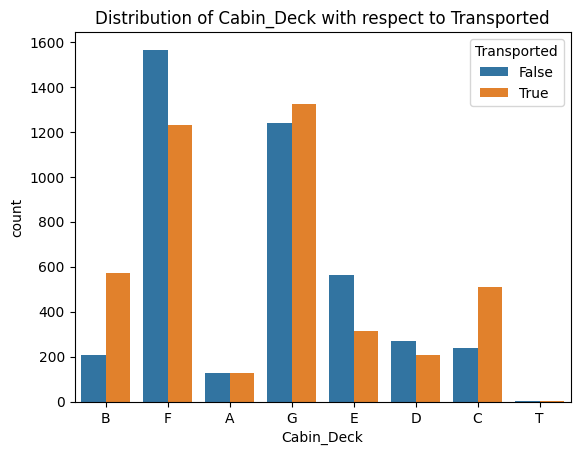

            Count  Percentage  Transported  Not Transported
Cabin_Deck                                                 
A             256    3.013892    49.609375        50.390625
B             779    9.171180    73.427471        26.572529
C             747    8.794443    68.005355        31.994645
D             478    5.627502    43.305439        56.694561
E             876   10.313162    35.730594        64.269406
F            2794   32.893807    43.987115        56.012885
G            2559   30.127149    51.621727        48.378273
T               5    0.058865    20.000000        80.000000


In [26]:
cabin_deck_summary = analyze_categorical_feature(df, "Cabin_Deck")
print(cabin_deck_summary)

- Majority of the passengers are staying on deck `F` and `G`.
- Chance of being transported is highest for passengers staying on deck `B` and `C`.

##### Cabin_Side

Cabin have two sides `P` (port) and `S` (starboard).

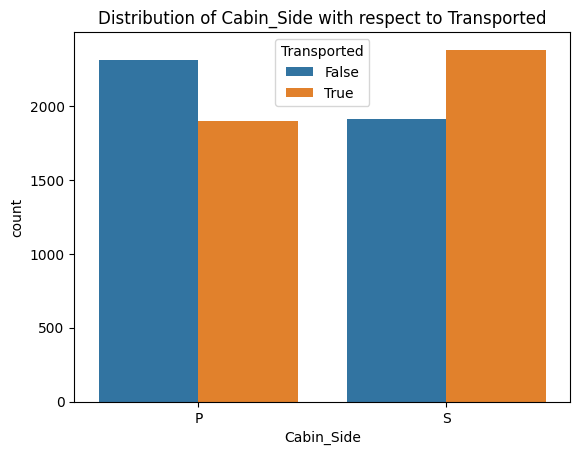

            Count  Percentage  Transported  Not Transported
Cabin_Side                                                 
P            4206   49.517306    45.126010        54.873990
S            4288   50.482694    55.503731        44.496269


In [27]:
cabin_side_summary = analyze_categorical_feature(df, "Cabin_Side")
print(cabin_side_summary)

While the number of passengers staying on both sides are almost same, the chance of being transported is higher for passengers staying on starboard side.
It means if you don't want to be transported to another dimension incase of a spacetime anomaly, you better stay on port side.

### Numerical Features

Let's analyze the numerical features in the dataset.

In [28]:
num_cols = df.select_dtypes(include=np.number).columns

df[num_cols].describe()

,Age,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Cabin_Number
count,8514.000000,8512.000000,8510.000000,8485.000000,8510.000000,8505.000000,8494.000000
mean,28.827930,224.687617,458.077203,173.729169,311.138778,304.854791,600.367671
std,14.489021,666.717663,1611.489240,604.696458,1136.705535,1145.717189,511.867226
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,19.000000,0.000000,0.000000,0.000000,0.000000,0.000000,167.250000
50%,27.000000,0.000000,0.000000,0.000000,0.000000,0.000000,427.000000
75%,38.000000,47.000000,76.000000,27.000000,59.000000,46.000000,999.000000
max,79.000000,14327.000000,29813.000000,23492.000000,22408.000000,24133.000000,1894.000000


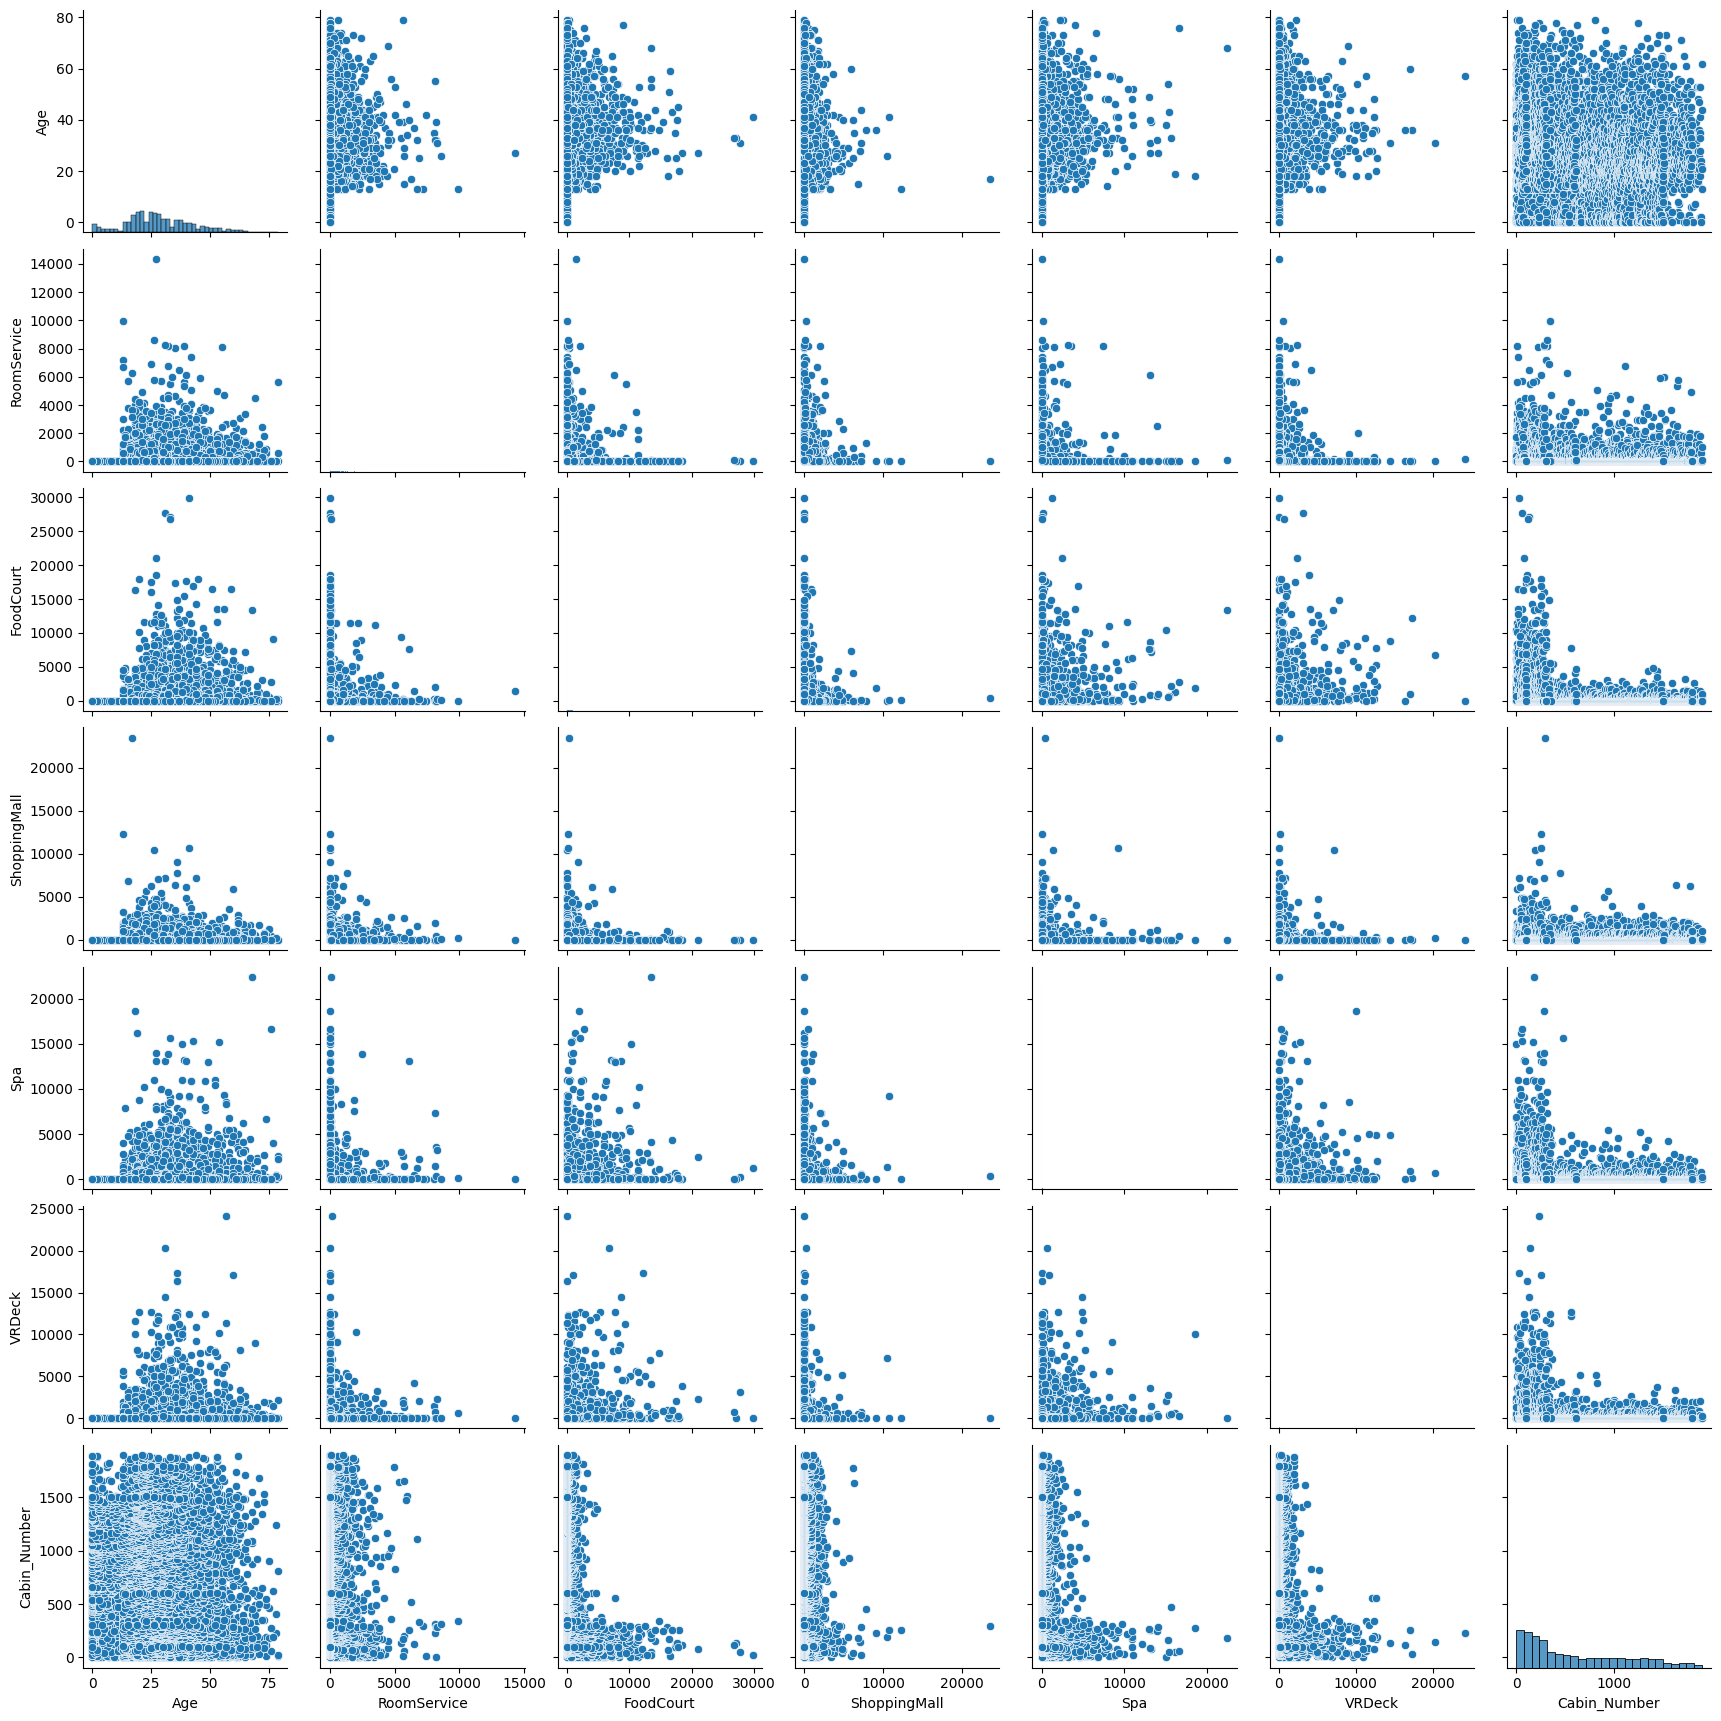

In [29]:
sns.pairplot(df[num_cols])
plt.show()

In [30]:
corr_matrix = df[num_cols].corr()
corr_matrix

,Age,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Cabin_Number
Age,1.000000,0.068723,0.130421,0.033133,0.123970,0.101007,-0.132255
RoomService,0.068723,1.000000,-0.015889,0.054480,0.010080,-0.019581,-0.008986
FoodCourt,0.130421,-0.015889,1.000000,-0.014228,0.221891,0.227995,-0.183429
ShoppingMall,0.033133,0.054480,-0.014228,1.000000,0.013879,-0.007322,0.001727
Spa,0.123970,0.010080,0.221891,0.013879,1.000000,0.153821,-0.131342
VRDeck,0.101007,-0.019581,0.227995,-0.007322,0.153821,1.000000,-0.139080
Cabin_Number,-0.132255,-0.008986,-0.183429,0.001727,-0.131342,-0.139080,1.000000


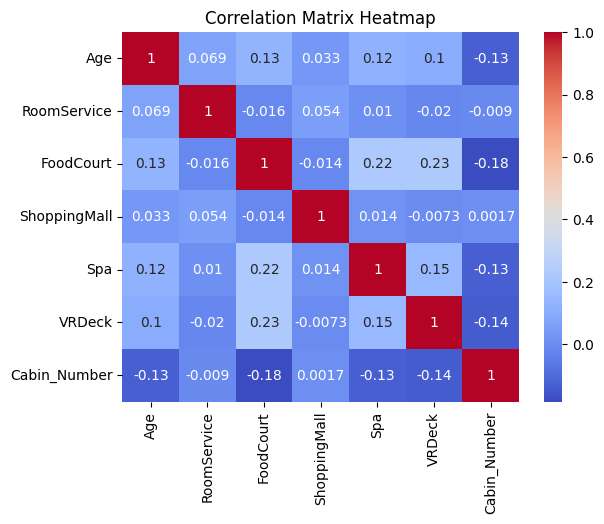

In [31]:
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm')
plt.title("Correlation Matrix Heatmap")
plt.show()

#### Age

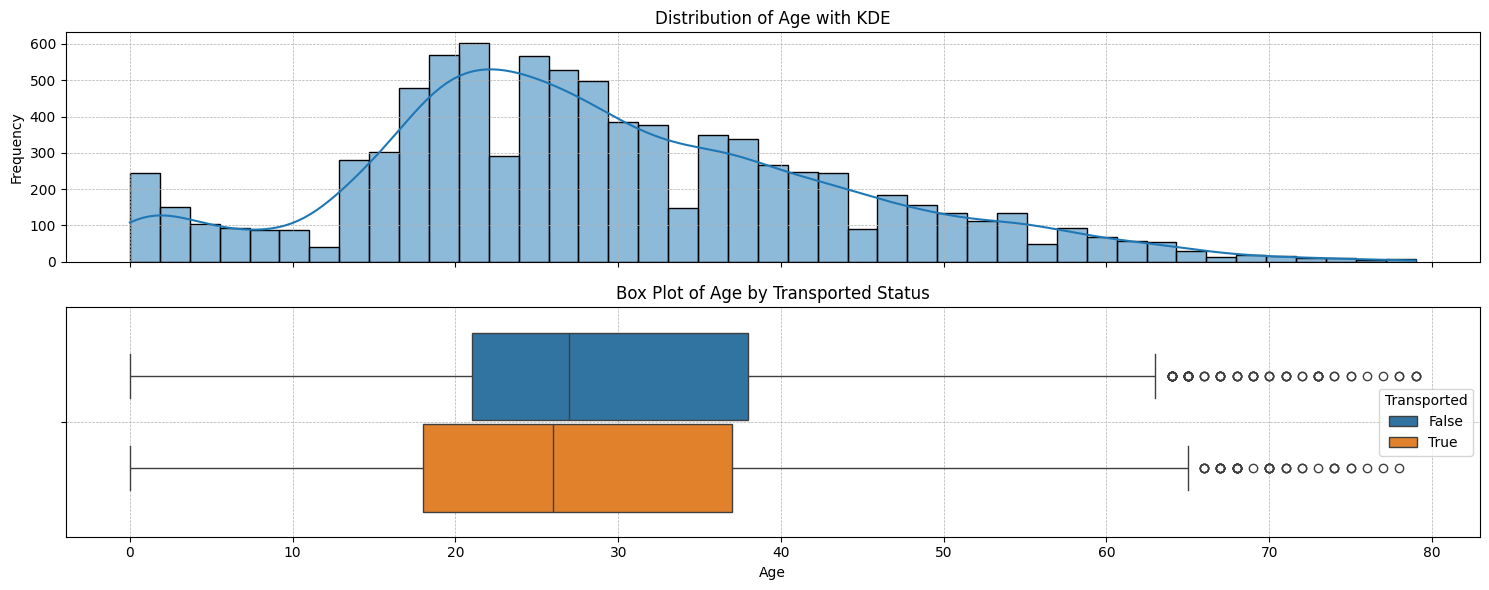

Outliers statistics of the Age column:



,count,mean,std,min,25%,50%,75%,max
Age,77.0,71.090909,3.53621,67.0,68.0,70.0,73.0,79.0


In [32]:
# Create the figure and subplots
fig, ax = plt.subplots(2, 1, figsize=(15, 6), sharex=True)

# First plot: Histogram with KDE
sns.histplot(df, x='Age', kde=True, ax=ax[0])
ax[0].set_title('Distribution of Age with KDE')
ax[0].set_ylabel('Frequency')
ax[0].grid(True, which='both', linestyle='--', linewidth=0.5)


# Second plot: Boxplot of Age by Transported
sns.boxplot(df, x='Age', ax=ax[1], hue='Transported', gap=0.05)
ax[1].set_title('Box Plot of Age by Transported Status')
ax[1].set_ylabel('')
ax[1].grid(True, which='both', linestyle='--', linewidth=0.5)

# Adjust layout for better spacing
plt.tight_layout()

# Display the plots
plt.show()

# Check the outliers in the Age column

# Calculate the first and third quartiles
Q1 = df.Age.quantile(0.25)
Q3 = df.Age.quantile(0.75)
IQR = Q3 - Q1

# Calculate the lower and upper bounds
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

# Check for outliers
outliers = df[(df.Age < lower_bound) | (df.Age > upper_bound)]
age_outliers = outliers.Age.describe()
age_outliers_df = age_outliers.to_frame().T
print(f"Outliers statistics of the Age column:\n")
age_outliers_df


**Age**:

- Majority of the passengers are between 18 and 30 years old.
- There are some outliers but these are seems to be valid ages. So we will keep them as it is. For building our model we will scale the age feature initially. Later on we can try other transformations.

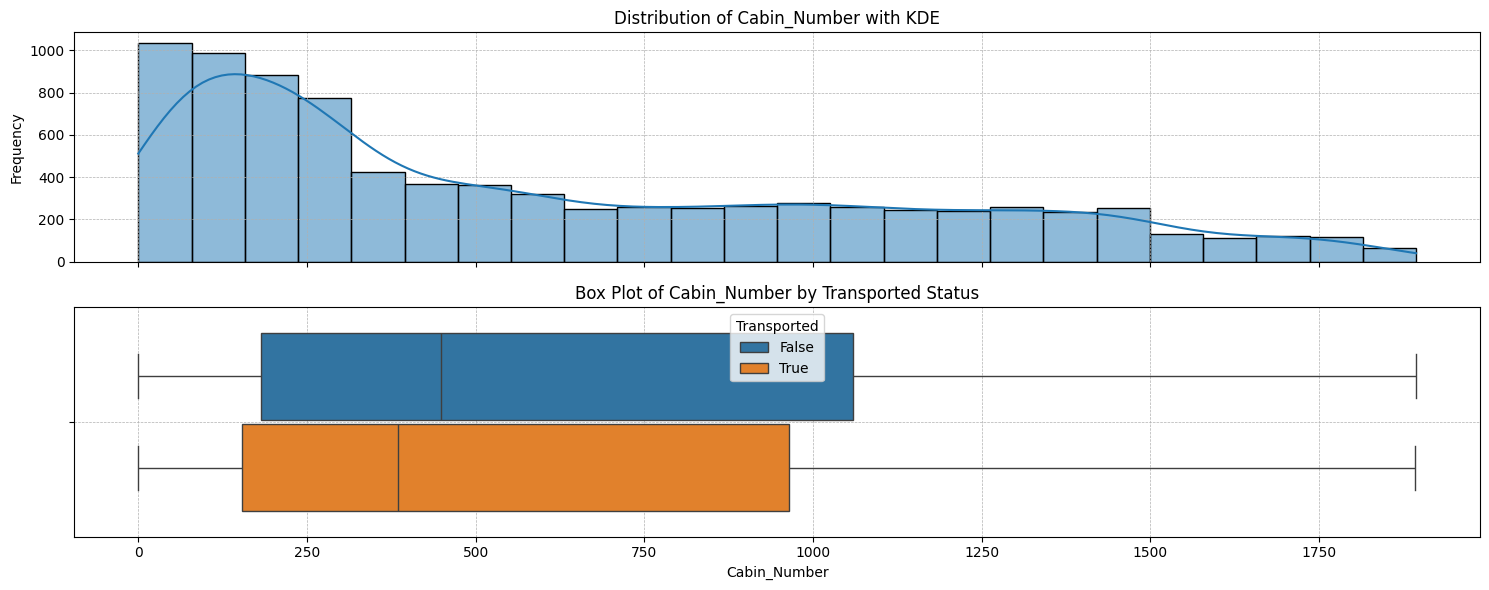

Outliers statistics of the Cabin_Number column:



,count,mean,std,min,25%,50%,75%,max
Cabin_Number,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [40]:
def analyze_numerical_distribution(df, feature_col, target_col=None, figsize=(15, 6)):
    """
    Analyze the distribution of a numerical feature and detect outliers.

    Parameters:
    - df: pandas DataFrame, the dataset containing the numerical feature.
    - feature_col: str, the name of the numerical feature column to analyze.
    - target_col: str, the target column to compare against (for the box plot). Optional.
    - figsize: tuple, the size of the figure for the plots.

    Returns:
    - outliers_df: pandas DataFrame, a summary of outliers in the specified feature column.
    """
    
    # Create the figure and subplots
    fig, ax = plt.subplots(2, 1, figsize=figsize, sharex=True)

    # First plot: Histogram with KDE
    sns.histplot(df, x=feature_col, kde=True, ax=ax[0])
    ax[0].set_title(f'Distribution of {feature_col} with KDE')
    ax[0].set_ylabel('Frequency')
    ax[0].grid(True, which='both', linestyle='--', linewidth=0.5)

    # Second plot: Boxplot of the feature by the target (if provided)
    if target_col:
        sns.boxplot(df, x=feature_col, ax=ax[1], hue=target_col, gap=0.05)
        ax[1].set_title(f'Box Plot of {feature_col} by {target_col} Status')
    else:
        sns.boxplot(df, x=feature_col, ax=ax[1])
        ax[1].set_title(f'Box Plot of {feature_col}')

    ax[1].set_ylabel('')
    ax[1].grid(True, which='both', linestyle='--', linewidth=0.5)

    # Adjust layout for better spacing
    plt.tight_layout()

    # Display the plots
    plt.show()

    # Check the outliers in the feature column
    Q1 = df[feature_col].quantile(0.25)
    Q3 = df[feature_col].quantile(0.75)
    IQR = Q3 - Q1

    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR

    # Check for outliers
    outliers = df[(df[feature_col] < lower_bound) | (df[feature_col] > upper_bound)]
    outliers_summary = outliers[feature_col].describe()
    outliers_df = outliers_summary.to_frame().T

    print(f"Outliers statistics of the {feature_col} column:\n")
    return outliers_df

# Example usage:
# outliers_df = analyze_numerical_distribution(df, feature_col='Age', target_col='Transported')
outliers_df = analyze_numerical_distribution(df, feature_col='Cabin_Number', target_col='Transported')
outliers_df


I created this function to check all the numerical features. But it's not very useful for all the features. So I will check the other numerical features separately. For `Cabin_Number`, it's working.

Even though the distribution of the Cabin_Number data is right skewed, it doesn't have any outliers. 

#### RoomService

Amount the passenger has billed at the RoomService.

<Axes: >

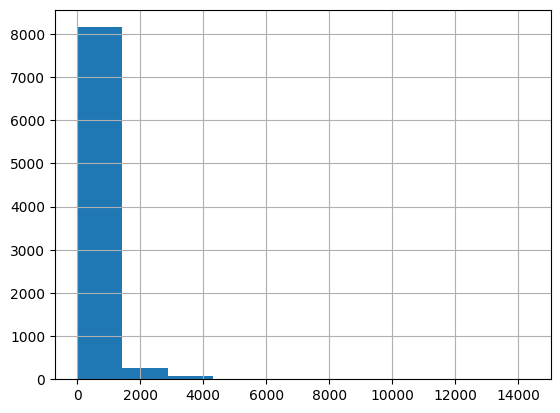

In [34]:
df.RoomService.hist()

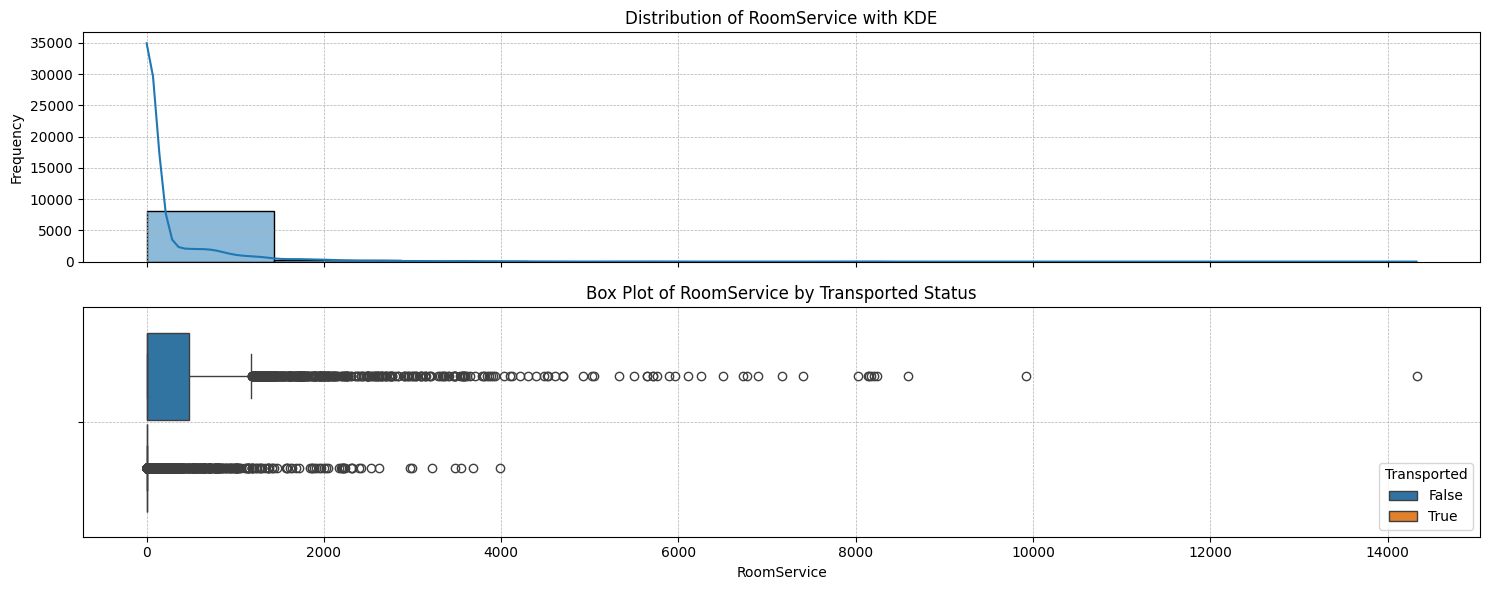

Statistics of the RoomService column:



,count,mean,std,min,25%,50%,75%,max
RoomService_Overall,8512.0,224.687617,666.717663,0.0,0.0,0.0,47.0,14327.0
RoomService_Lower_Outliers,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
RoomService_Upper_Outliers,1861.0,1010.432563,1114.635865,118.0,374.0,701.0,1217.0,14327.0


In [35]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

def analyze_numerical_distribution(df, feature_col, target_col=None, figsize=(15, 6), bins=30):
    """
    Analyze the distribution of a numerical feature and detect outliers.

    Parameters:
    - df: pandas DataFrame, the dataset containing the numerical feature.
    - feature_col: str, the name of the numerical feature column to analyze.
    - target_col: str, the target column to compare against (for the box plot). Optional.
    - figsize: tuple, the size of the figure for the plots.
    - bins: int, the number of bins for the histogram.

    Returns:
    - summary_df: pandas DataFrame, a summary of statistics for the overall feature data and outliers.
    """
    
    # Create the figure and subplots
    fig, ax = plt.subplots(2, 1, figsize=figsize, sharex=True)

    # First plot: Histogram with KDE
    sns.histplot(df, x=feature_col, kde=True, ax=ax[0], bins=bins)
    ax[0].set_title(f'Distribution of {feature_col} with KDE')
    ax[0].set_ylabel('Frequency')
    ax[0].grid(True, which='both', linestyle='--', linewidth=0.5)

    # Second plot: Boxplot of the feature by the target (if provided)
    if target_col:
        sns.boxplot(df, x=feature_col, ax=ax[1], hue=target_col, gap=0.05)
        ax[1].set_title(f'Box Plot of {feature_col} by {target_col} Status')
    else:
        sns.boxplot(df, x=feature_col, ax=ax[1])
        ax[1].set_title(f'Box Plot of {feature_col}')

    ax[1].set_ylabel('')
    ax[1].grid(True, which='both', linestyle='--', linewidth=0.5)

    # Adjust layout for better spacing
    plt.tight_layout()

    # Display the plots
    plt.show()

    # Calculate overall statistics
    overall_summary = df[feature_col].describe().to_frame().T
    overall_summary.index = [f'{feature_col}_Overall']

    # Calculate the lower and upper bounds for outliers
    Q1 = df[feature_col].quantile(0.25)
    Q3 = df[feature_col].quantile(0.75)
    IQR = Q3 - Q1

    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR

    # Identify lower and upper bound outliers
    lower_outliers = df[df[feature_col] < lower_bound]
    upper_outliers = df[df[feature_col] > upper_bound]

    # Get descriptive statistics for lower and upper outliers
    lower_outliers_summary = lower_outliers[feature_col].describe().to_frame().T
    lower_outliers_summary.index = [f'{feature_col}_Lower_Outliers']

    upper_outliers_summary = upper_outliers[feature_col].describe().to_frame().T
    upper_outliers_summary.index = [f'{feature_col}_Upper_Outliers']

    # Combine overall statistics with lower and upper outlier statistics
    summary_df = pd.concat([overall_summary, lower_outliers_summary, upper_outliers_summary])

    print(f"Statistics of the {feature_col} column:\n")
    return summary_df


outliers_df = analyze_numerical_distribution(df, feature_col='RoomService', target_col='Transported', bins=10)
outliers_df

**RoomService**:



#### FoodCourt

Amount the passenger has billed at the FoodCourt.

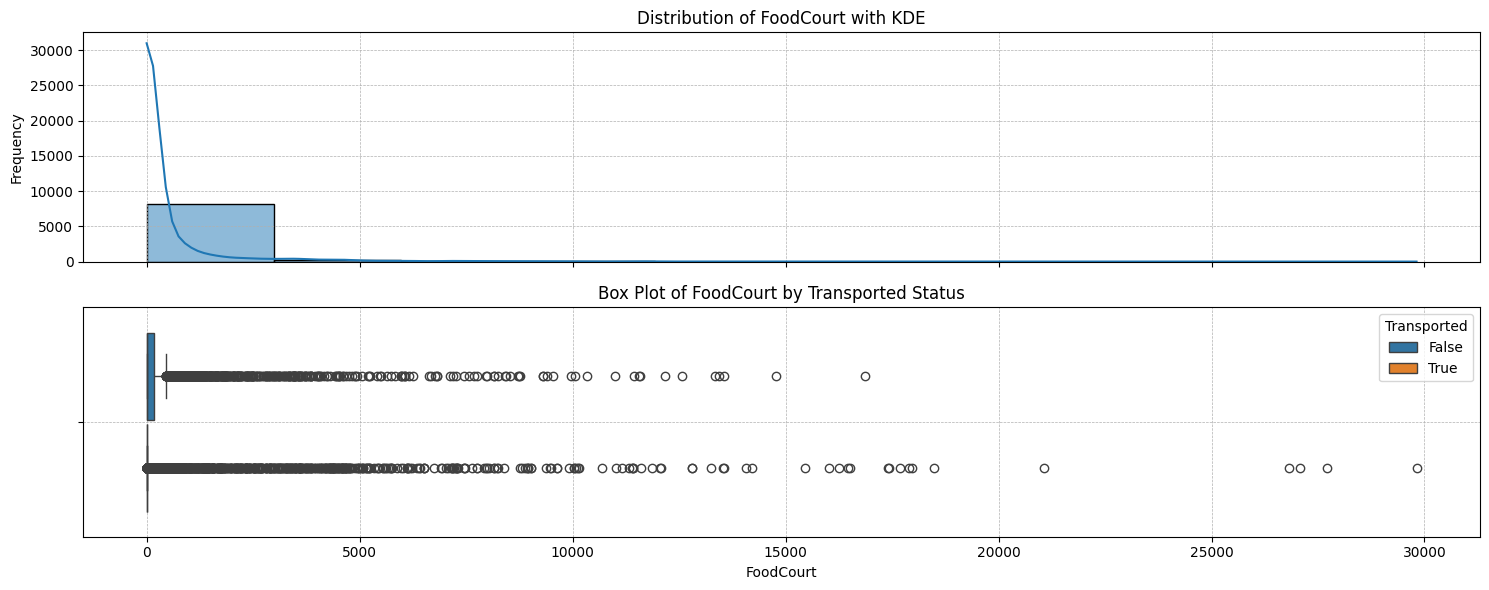

Statistics of the FoodCourt column:



,count,mean,std,min,25%,50%,75%,max
FoodCourt_Overall,8510.0,458.077203,1611.48924,0.0,0.0,0.0,76.0,29813.0
FoodCourt_Lower_Outliers,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
FoodCourt_Upper_Outliers,1823.0,2107.382337,2942.98597,192.0,540.5,914.0,2514.5,29813.0


In [36]:
analyze_numerical_distribution(df, feature_col='FoodCourt', target_col='Transported', bins=10)

#### ShoppingMall

Amount the passenger has billed at the ShoppingMall.

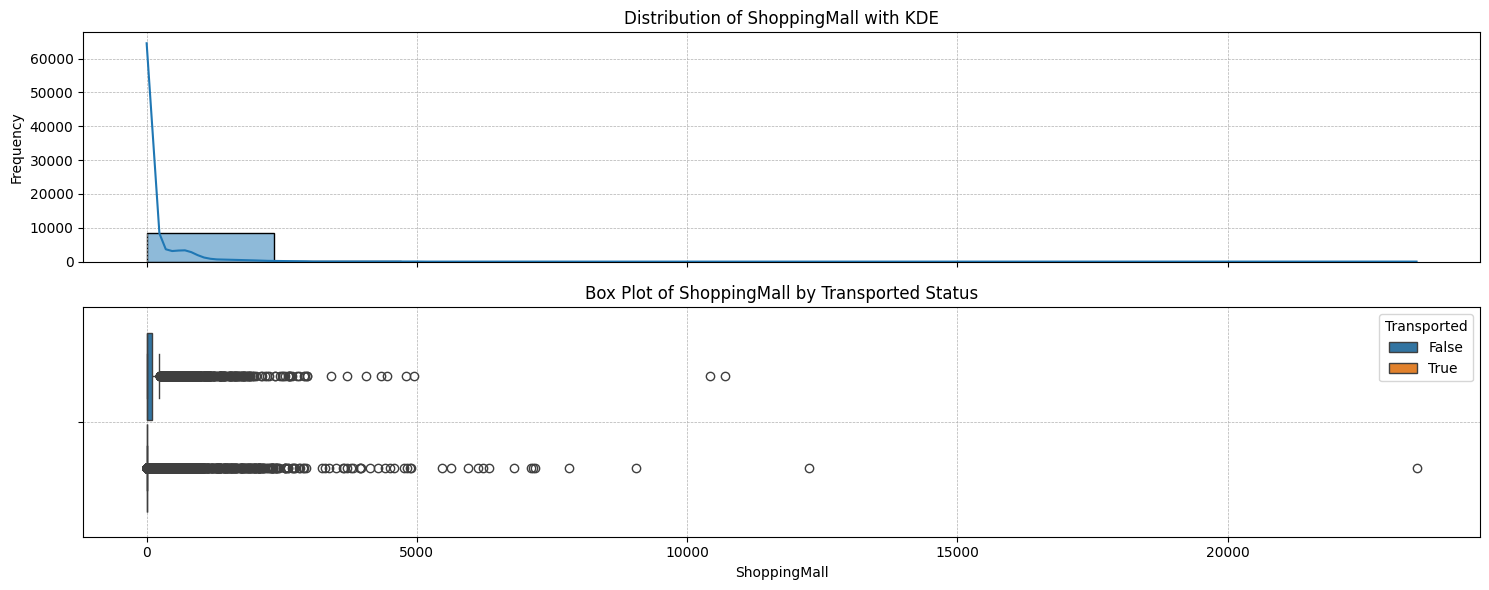

Statistics of the ShoppingMall column:



,count,mean,std,min,25%,50%,75%,max
ShoppingMall_Overall,8485.0,173.729169,604.696458,0.0,0.0,0.0,27.0,23492.0
ShoppingMall_Lower_Outliers,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
ShoppingMall_Upper_Outliers,1829.0,795.459814,1097.125444,68.0,238.0,576.0,892.0,23492.0


In [37]:
analyze_numerical_distribution(df, feature_col='ShoppingMall', target_col='Transported', bins=10)

#### Spa

Amount the passenger has billed at the Spa.

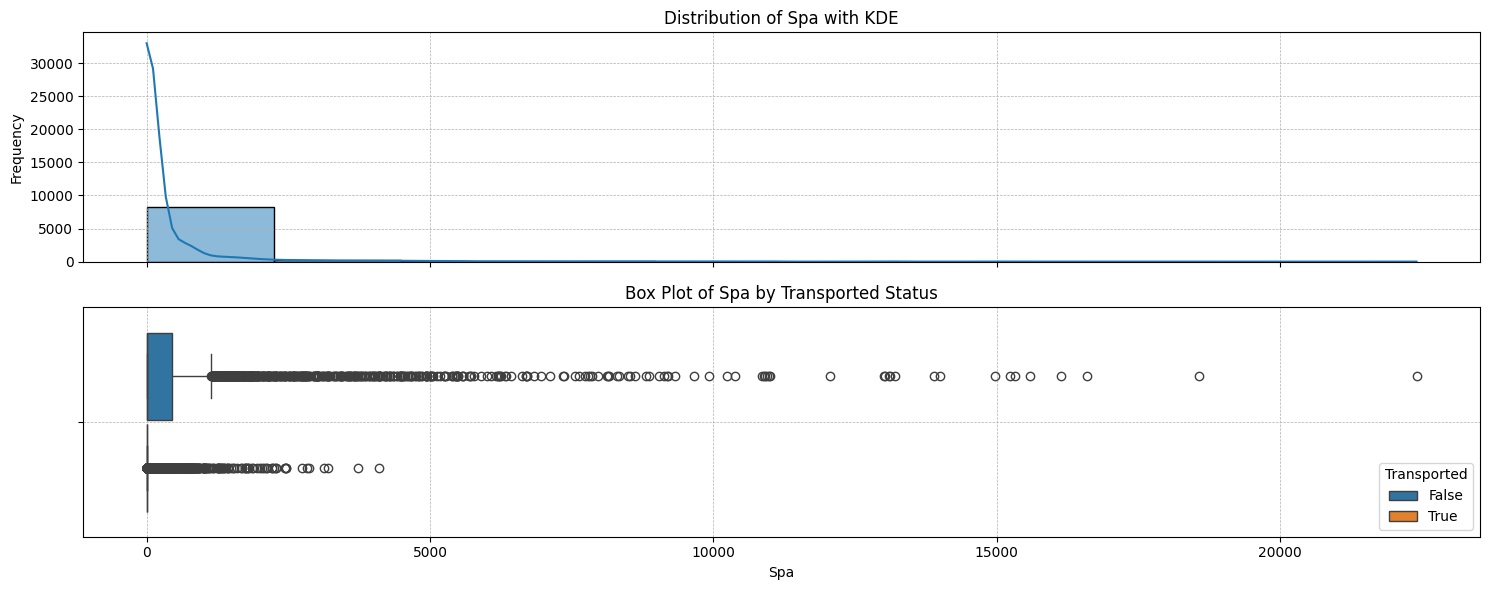

Statistics of the Spa column:



,count,mean,std,min,25%,50%,75%,max
Spa_Overall,8510.0,311.138778,1136.705535,0.0,0.0,0.0,59.00,22408.0
Spa_Lower_Outliers,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Spa_Upper_Outliers,1788.0,1452.201342,2121.577745,148.0,369.0,710.5,1529.25,22408.0


In [38]:
analyze_numerical_distribution(df, feature_col='Spa', target_col='Transported', bins=10)

#### VRDeck

Amount the passenger has billed at the VRDeck.

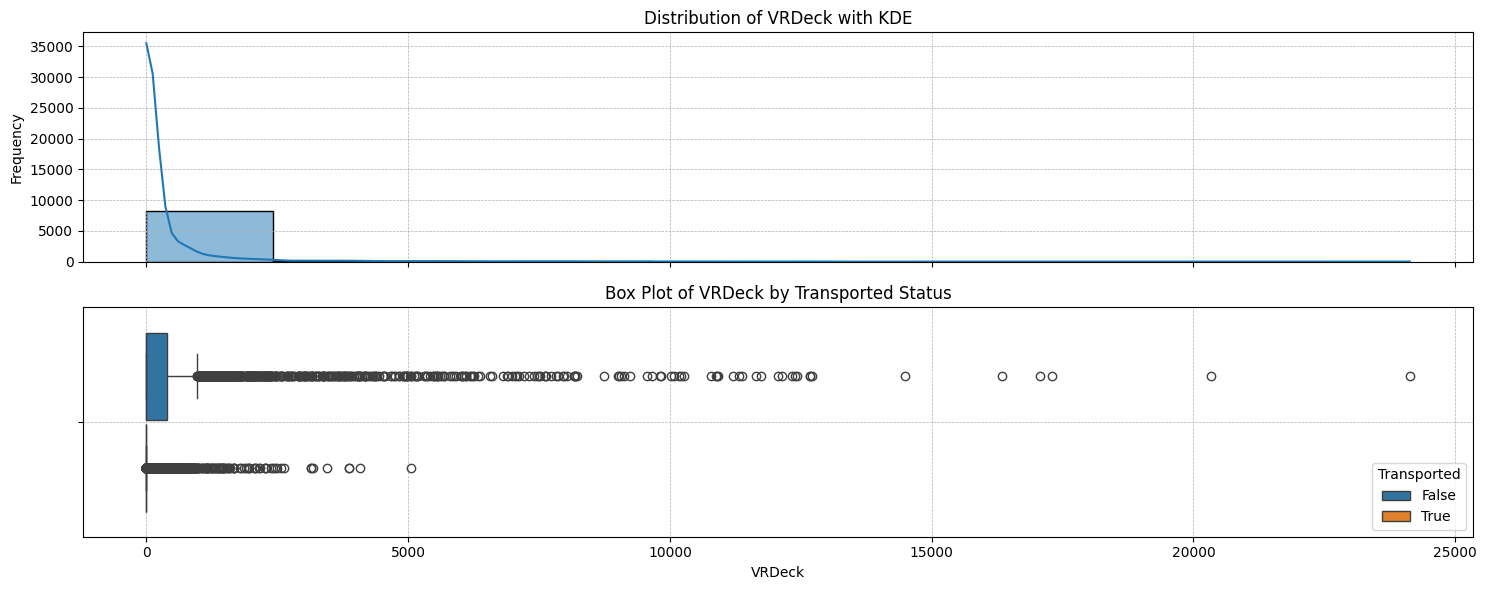

Statistics of the VRDeck column:



,count,mean,std,min,25%,50%,75%,max
VRDeck_Overall,8505.0,304.854791,1145.717189,0.0,0.0,0.0,46.0,24133.0
VRDeck_Lower_Outliers,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
VRDeck_Upper_Outliers,1809.0,1413.685462,2147.214444,116.0,356.0,693.0,1435.0,24133.0


In [39]:
analyze_numerical_distribution(df, feature_col='VRDeck', target_col='Transported', bins=10)

All the numerical features except `Cabin_Number` and `Age` are very highly right skewed. 
For our initial model we will scale these features. Later on we can try log transformation or other transformations.

## Conclusion

We have done the exploratory data analysis of the dataset. We have checked the distribution of the target variable and analyzed the catagorical and numerical features. We have also checked the missing values in the dataset. We will impute the missing values with some strategy and build our first model. Later on we can try other strategies for imputing missing values and transformations for the numerical features to improve our model.